# Setup

In [1]:
import gdown
from zipfile import ZipFile
import matplotlib.pyplot as plt

import numpy as np
import os

import random

import tensorflow as tf

from pathlib import Path

from keras import applications

from keras import layers
from keras import losses
from keras import ops

from keras import optimizers

from keras import metrics

from keras import Model

from keras.applications import resnet



target_shape = (200, 200)

# Load the dataset

In [2]:
# Define the target directory for dataset files
# DATA_PATH = "C:/2024/Image similarity estimation/data"

In [3]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [4]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=6e1dee12-541f-400f-9a78-26def6876ee7
To: /content/left.zip
100% 104M/104M [00:01<00:00, 96.6MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=1ca2d7af-c4d1-44b7-8686-b147d0ea49b1
To: /content/right.zip
100% 10

# Preparing the data

In [5]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [6]:
def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [7]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

In [8]:
# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [9]:
# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])




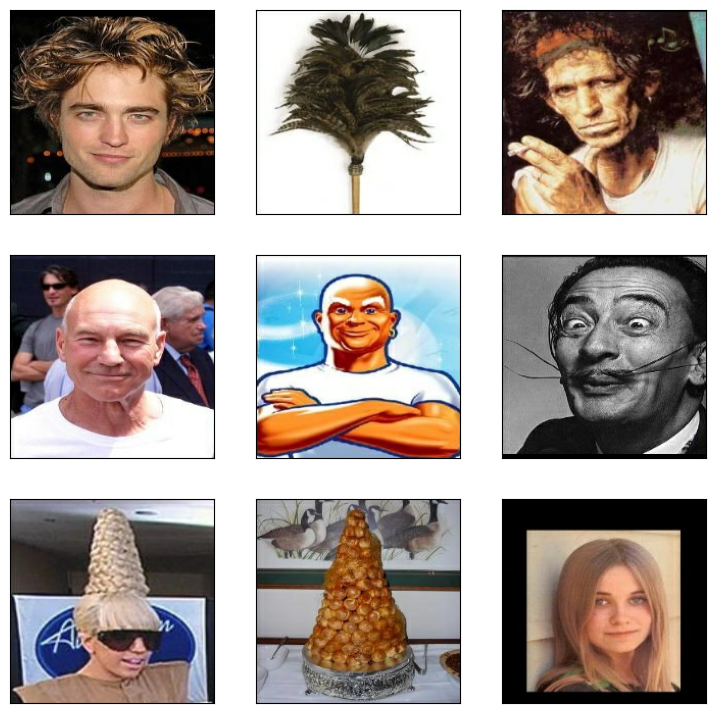

In [11]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# Setting up the embedding generator model

In [12]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Setting up the Siamese Network model

In [13]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


In [14]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))


In [15]:
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

# Putting everything together

In [16]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

# Training

In [17]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 144s 579ms/step - loss: 0.6287 - val_loss: 0.3998
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 432ms/step - loss: 0.3886 - val_loss: 0.3720
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 429ms/step - loss: 0.3611 - val_loss: 0.3440
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 422ms/step - loss: 0.3420 - val_loss: 0.3338
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 411ms/step - loss: 0.3254 - val_loss: 0.3186
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 406ms/step - loss: 0.3350 - val_loss: 0.3169
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 408ms/step - loss: 0.3102 - val_loss: 0.3323
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 404ms/step - loss: 0.2973 - val_loss: 0.3224
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 408ms/step - loss: 0.2849 - val_loss: 0.3295
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 405ms/step - loss: 0.2791 - val_loss: 0.3274


# Inspecting what the network has learned

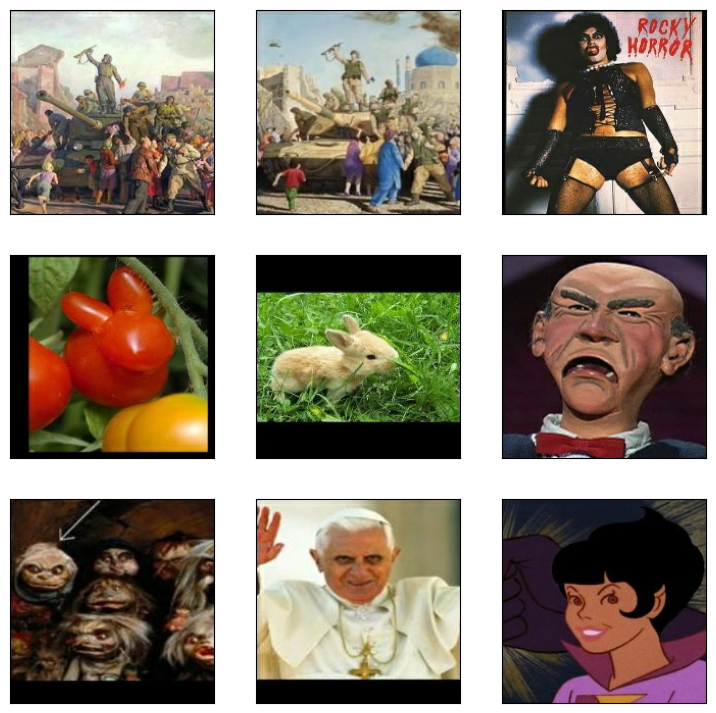

In [19]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [20]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99280083
Negative similarity 0.98917156


In [23]:
# Save the model weights
model_path = "siamese_model_weights.weights.h5"
siamese_model.save_weights(model_path)
print(f"Model weights saved to {model_path}")



Model weights saved to siamese_model_weights.weights.h5


In [24]:
# Load the model weights (to test later)
siamese_model.load_weights(model_path)
print("Model weights loaded.")



Model weights loaded.


In [28]:
import matplotlib.pyplot as plt

# Updated function to test the model and plot the images with distances
def test_model_with_visualization(anchor_image_path, positive_image_path, negative_image_path):
    # Preprocess the test images
    anchor_image = preprocess_image(anchor_image_path)
    positive_image = preprocess_image(positive_image_path)
    negative_image = preprocess_image(negative_image_path)

    # Predict distances
    distances = siamese_model.siamese_network(
        [tf.expand_dims(anchor_image, 0), tf.expand_dims(positive_image, 0), tf.expand_dims(negative_image, 0)]
    )
    ap_distance, an_distance = distances
    print("Anchor-Positive Distance:", ap_distance.numpy())
    print("Anchor-Negative Distance:", an_distance.numpy())

    # Plot the images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Function to plot an image in an axis with a title
    def plot_image(ax, image, title):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")

    # Convert images to displayable format (remove batch dimension, convert to numpy)
    anchor_image_np = anchor_image.numpy()
    positive_image_np = positive_image.numpy()
    negative_image_np = negative_image.numpy()

    # Plot anchor, positive, and negative images with distance information
    plot_image(axs[0], anchor_image_np, "Anchor Image")
    plot_image(axs[1], positive_image_np, f"Positive Image\nDistance: {ap_distance.numpy()[0]:.4f}")
    plot_image(axs[2], negative_image_np, f"Negative Image\nDistance: {an_distance.numpy()[0]:.4f}")

    plt.show()

    # Check if the model finds the anchor and positive images closer than the anchor and negative images
    if ap_distance < an_distance:
        print("Model prediction: Anchor is closer to Positive (correct)")
    else:
        print("Model prediction: Anchor is closer to Negative (incorrect)")


